In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel('CPI_monthly_2025_changes.xlsx', skiprows=11)
print(df.shape)
df.head()

(1344, 4)


c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Series ID,Year,Period,Value
0,CUUR0000SA0,1913,M02,0.0
1,CUUR0000SA0,1913,M03,0.0
2,CUUR0000SA0,1913,M04,0.0
3,CUUR0000SA0,1913,M05,-1.0
4,CUUR0000SA0,1913,M06,1.0


In [3]:
df.columns

Index(['Series ID', 'Year', 'Period', 'Value'], dtype='object')

In [4]:
df = df.drop(columns=['Series ID'])
print(df.shape)
df.head()

(1344, 3)


,Year,Period,Value
0,1913,M02,0.0
1,1913,M03,0.0
2,1913,M04,0.0
3,1913,M05,-1.0
4,1913,M06,1.0


In [5]:
df = df[df['Period'].str.startswith('M')]


In [6]:
# Create the "Date" column:
# - Year is taken directly from the 'Year' column
# - Month is extracted from the 'Period' column (e.g., 'M01' → '01')
# - Day is fixed as '01'
df['Date'] = df['Year'].astype(str) + '-' + df['Period'].str[1:] + '-01'
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Year,Period,Value,Date
0,1913,M02,0.0,1913-02-01
1,1913,M03,0.0,1913-03-01
2,1913,M04,0.0,1913-04-01
3,1913,M05,-1.0,1913-05-01
4,1913,M06,1.0,1913-06-01


In [7]:
df = df[['Date', 'Value']]  # Reorder columns
df.columns = ['timestamp', 'CPI']  # Rename columns for consistency
df.head()

,timestamp,CPI
0,1913-02-01,0.0
1,1913-03-01,0.0
2,1913-04-01,0.0
3,1913-05-01,-1.0
4,1913-06-01,1.0


In [8]:
df = df.set_index('timestamp')
df.head()

,CPI
timestamp,
1913-02-01,0.0
1913-03-01,0.0
1913-04-01,0.0
1913-05-01,-1.0
1913-06-01,1.0


## Exploratory Data Analysis

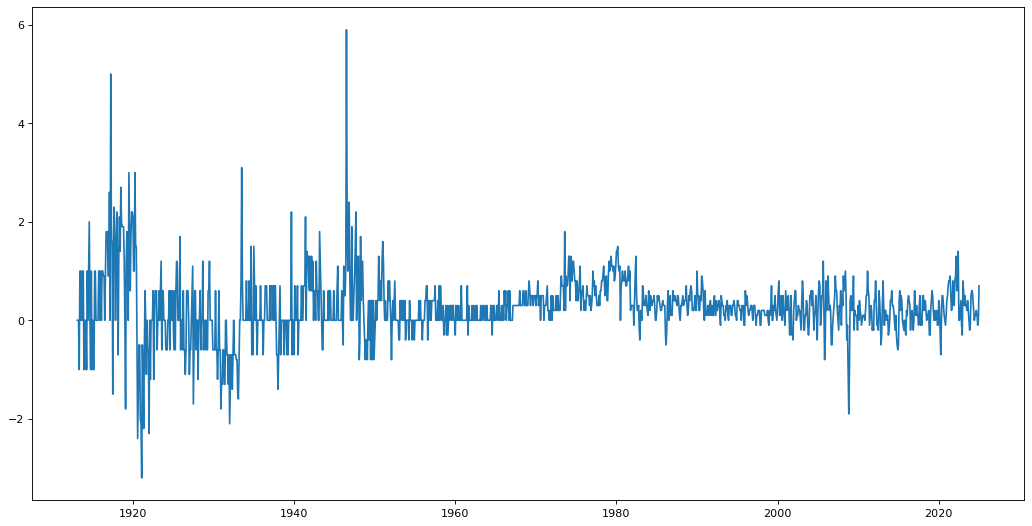

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)
plt.plot(df.index,df.CPI)

## CHECK OUTLIER

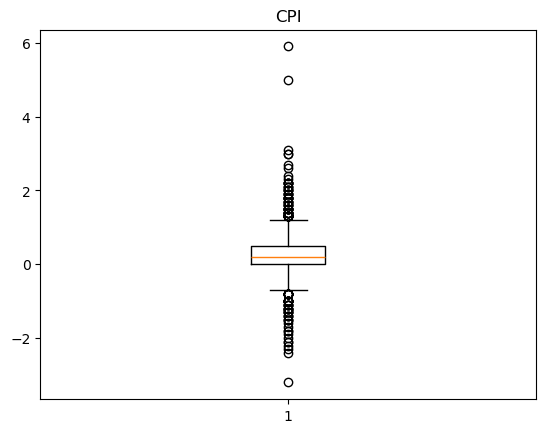

In [10]:
def box_plot(df,i):
  plt.boxplot(df.iloc[:,i])
  plt.title(df.columns.values.tolist()[i])
  plt.show()
box_plot(df,0)

In [11]:

q1 = np.percentile(df['CPI'],25)
q3 = np.percentile(df['CPI'],75)
boolean_condition = (df['CPI'] < q1 - (q3-q1)*1.3) | (df['CPI'] > q3 + (q3-q1)*1.3)
column_name = 'CPI'
new_value = np.mean(df['CPI'])

df.loc[boolean_condition, column_name] = new_value
df.head()

,CPI
timestamp,
1913-02-01,0.000000
1913-03-01,0.000000
1913-04-01,0.000000
1913-05-01,0.260045
1913-06-01,1.000000


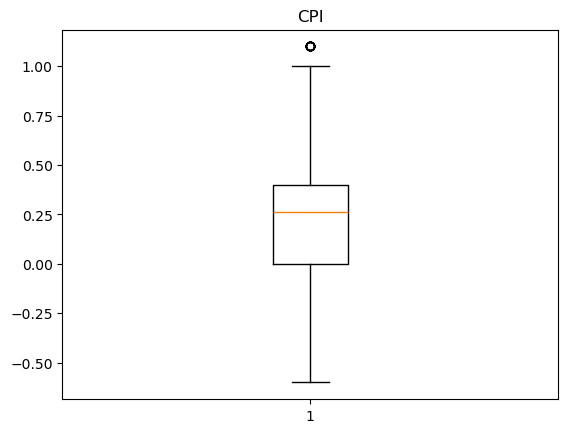

In [12]:

box_plot(df,0)

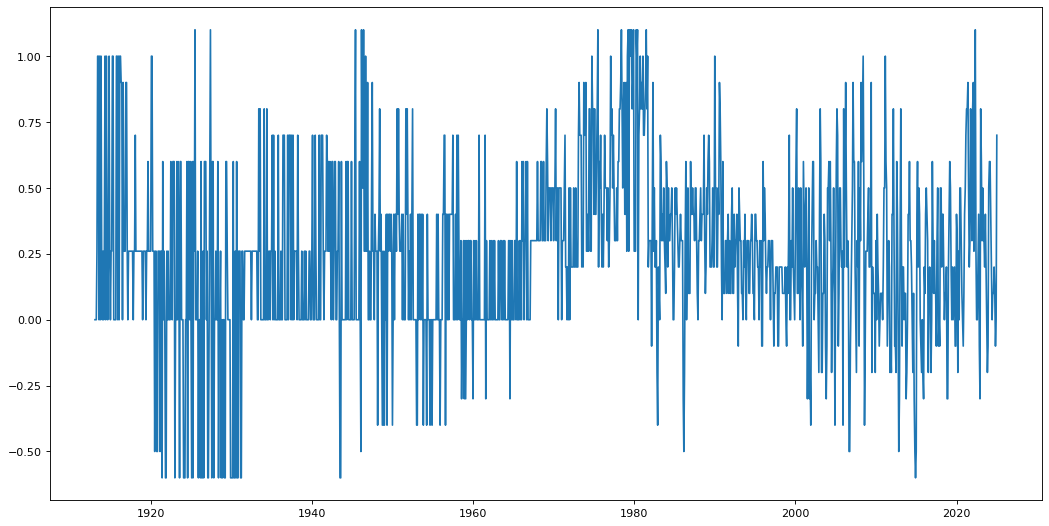

In [13]:
figure(figsize=(16, 8), dpi=80)
plt.plot(df.index,df.CPI)

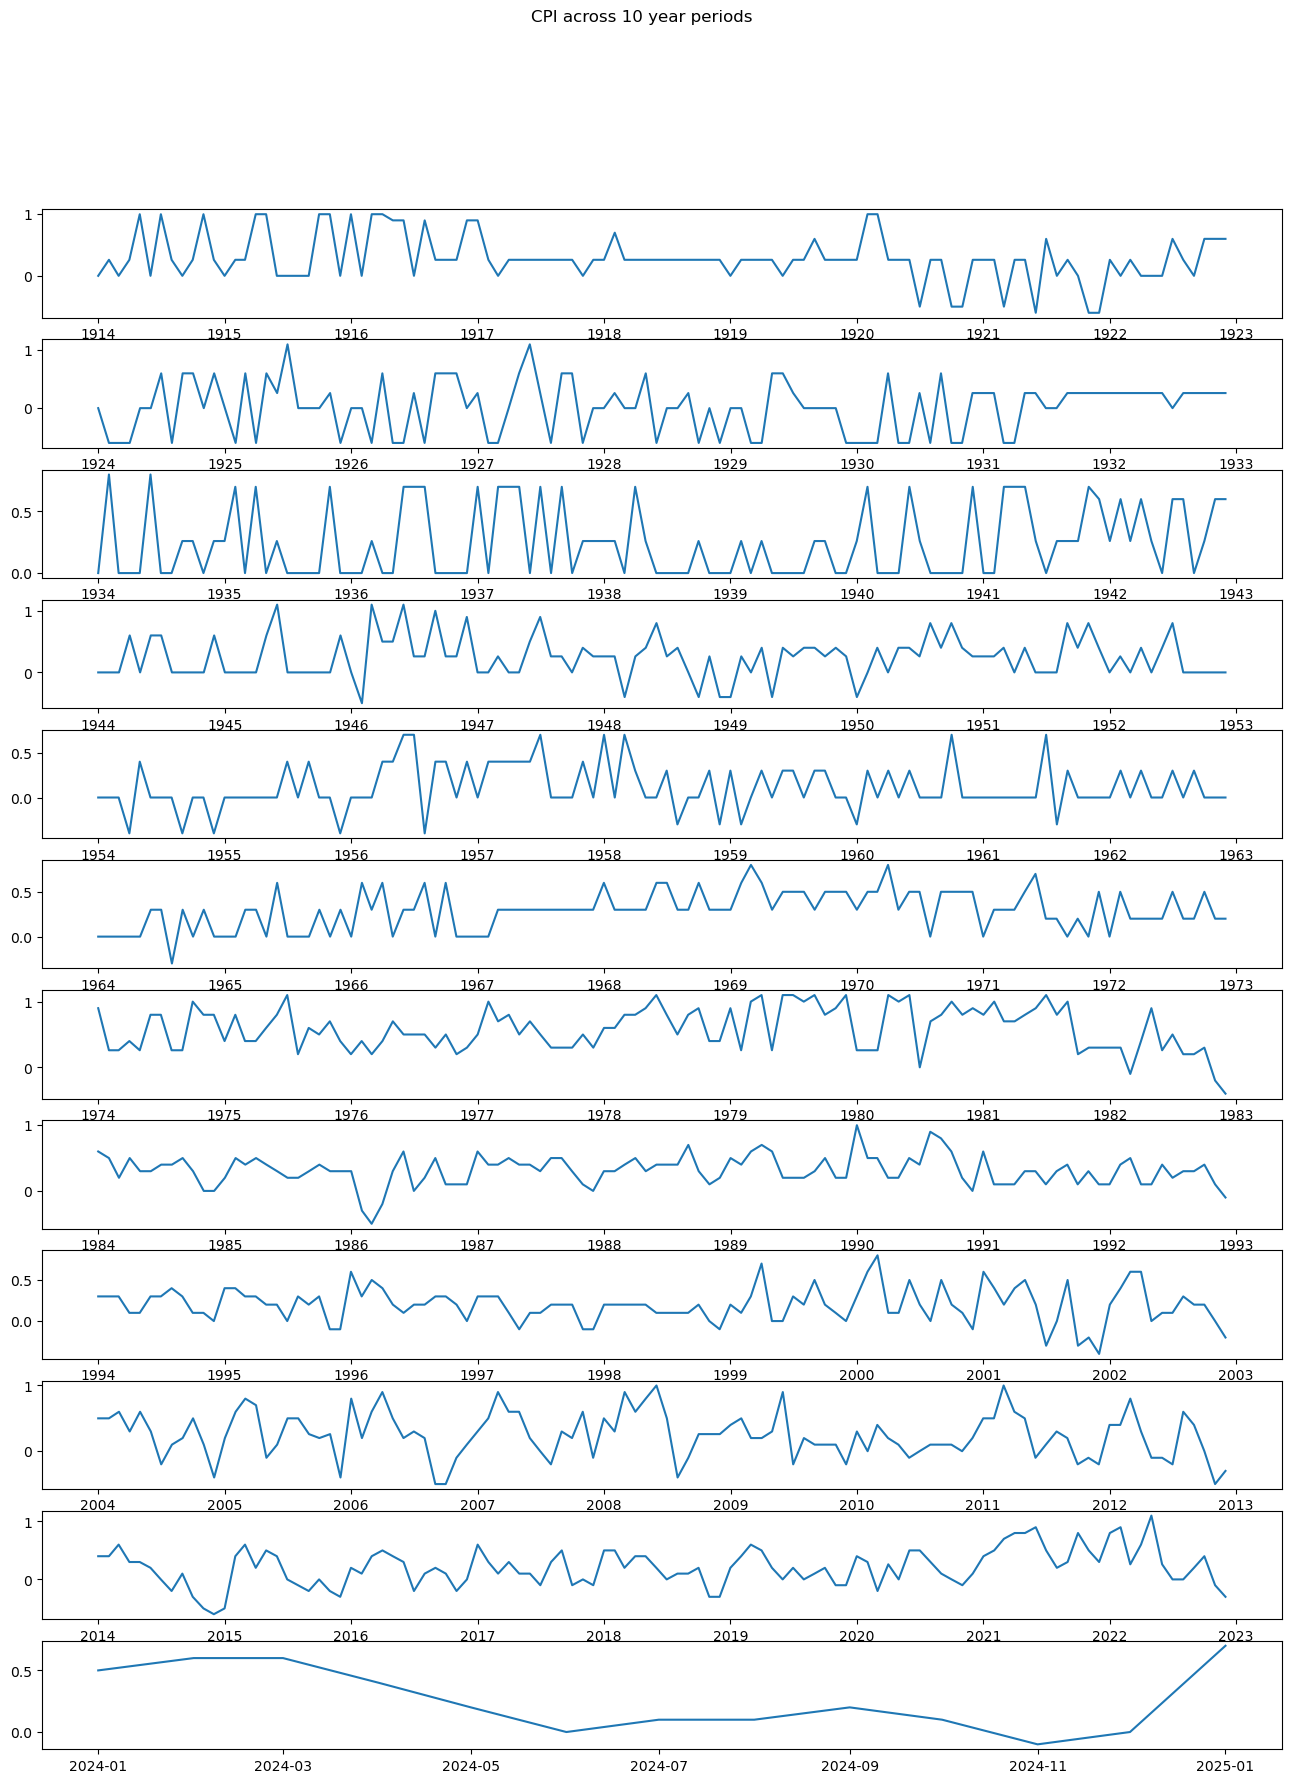

In [14]:

from pandas.tseries.offsets import YearEnd
plt.rc("figure",figsize=(16,20))
year = df.index.year.min()

fig, axs = plt.subplots((df.index.year.max() - df.index.year.min())//10 + 1)
fig.suptitle('CPI across 10 year periods')
count = 0

while year in df.index.year:
  df_temp = df[(df.index.year > year) & (df.index.year < year+10)]
  axs[count].plot(df_temp.index,df_temp.CPI)
  year = year + 10
  count = count + 1

## DECOMPOSITION

In [15]:
# !pip install statsmodels

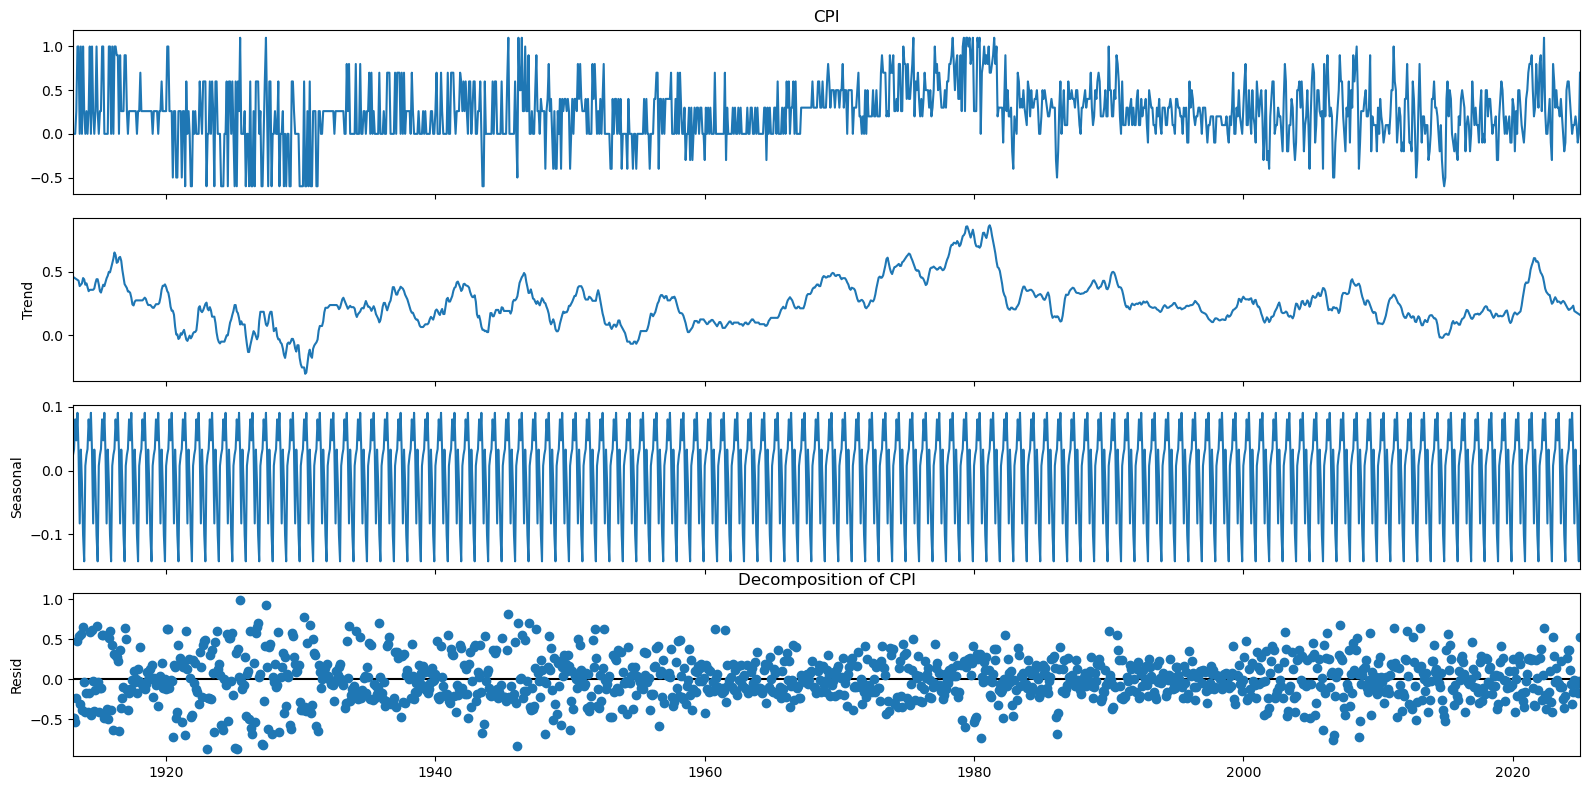

In [16]:

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rc("figure",figsize=(16,8))

def decompose(df, i):
  series = df.iloc[:,i]
  result = seasonal_decompose(series, model='additive',extrapolate_trend='freq',period=12)
  result.plot()
  plt.title('Decomposition of '+ df.columns.values.tolist()[i])
  plt.show()
  return result
result = decompose(df, 0)

## Stationarity

In [17]:

from statsmodels.tsa.stattools import adfuller

def ADF_Test(df,df_adf,i):	
	series = df.iloc[:,i]
	X = series.values
	result = adfuller(X)
	df_adf_i = pd.DataFrame({'Output':df.columns.values.tolist()[i],'ADF Statistic':result[0],'p-value':result[1],'CriticalValues':result[4]})
	df_adf = df_adf._append(df_adf_i,ignore_index = True)
	return df_adf

In [18]:

df_adf = pd.DataFrame()
df_adf = ADF_Test(df,df_adf,0)
df_adf
     

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-3.838417,0.002538,-3.435314
1,CPI,-3.838417,0.002538,-2.863732
2,CPI,-3.838417,0.002538,-2.567937


## Removing seasonality to make data stationary

In [19]:
df_nonseasonal = pd.DataFrame()

# Option 1: Use fillna
df_nonseasonal['CPI'] = df['CPI'] - df.shift(12)['CPI'].fillna(0)

# Option 2: Use replace with np.nan
# df_nonseasonal['CPI'] = df['CPI'] - df.shift(12).replace(np.nan, 0)['CPI']

df_nonseasonal.head()
     

,CPI
timestamp,
1913-02-01,0.000000
1913-03-01,0.000000
1913-04-01,0.000000
1913-05-01,0.260045
1913-06-01,1.000000


In [20]:

df_adf = pd.DataFrame()
df_adf = ADF_Test(df_nonseasonal,df_adf,0)
df_adf

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-11.35136,9.976595e-21,-3.435314
1,CPI,-11.35136,9.976595e-21,-2.863732
2,CPI,-11.35136,9.976595e-21,-2.567937


## Subtracting Lags to make data stationary

In [21]:
# Option 1: Replace np.nan
df_nonseasonal['lag1'] = df_nonseasonal['CPI'] - df_nonseasonal.shift(1).replace(np.nan, 0)['CPI']

# Option 2: Using fillna to replace NaN values with 0
df_nonseasonal['lag1'] = df_nonseasonal['CPI'] - df_nonseasonal.shift(1)['CPI'].fillna(0)

df_nonseasonal.head()

,CPI,lag1
timestamp,,
1913-02-01,0.000000,0.000000
1913-03-01,0.000000,0.000000
1913-04-01,0.000000,0.000000
1913-05-01,0.260045,0.260045
1913-06-01,1.000000,0.739955


In [22]:
df_adf = pd.DataFrame()
df_adf = ADF_Test(pd.DataFrame(df_nonseasonal['lag1']),df_adf,0)
df_adf
     

,Output,ADF Statistic,p-value,CriticalValues
0,lag1,-11.113435,3.612137e-20,-3.435314
1,lag1,-11.113435,3.612137e-20,-2.863732
2,lag1,-11.113435,3.612137e-20,-2.567937


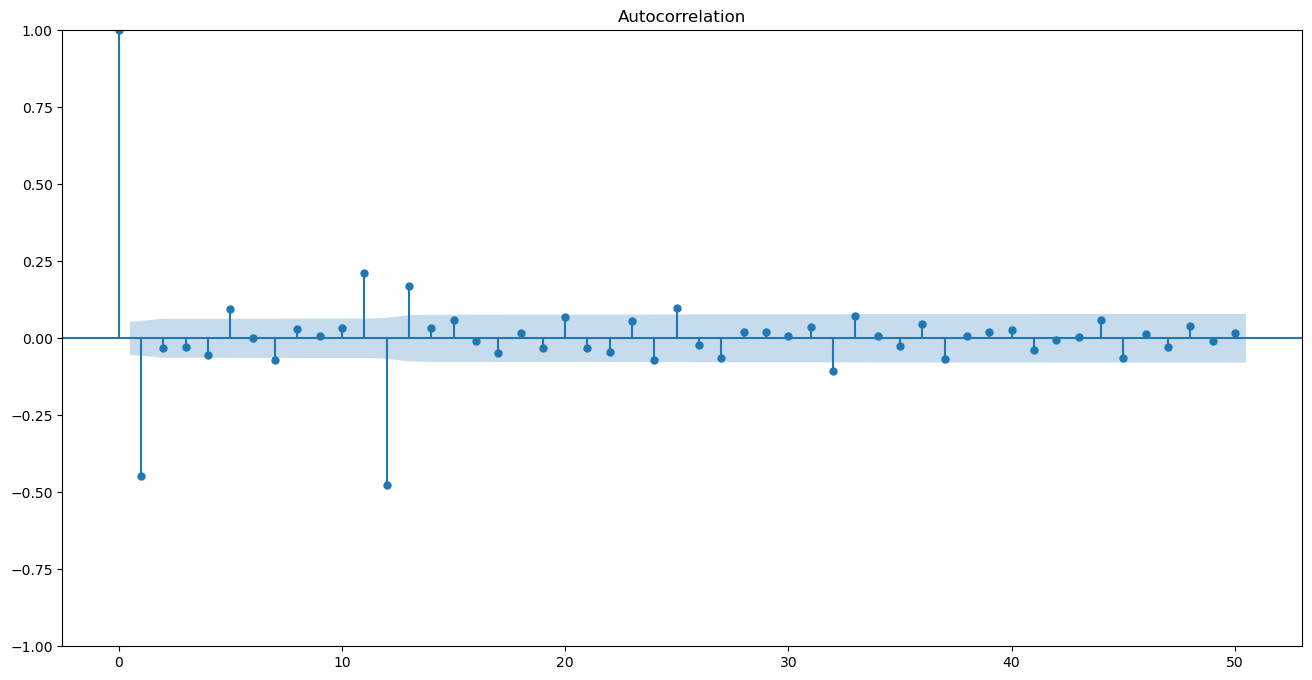

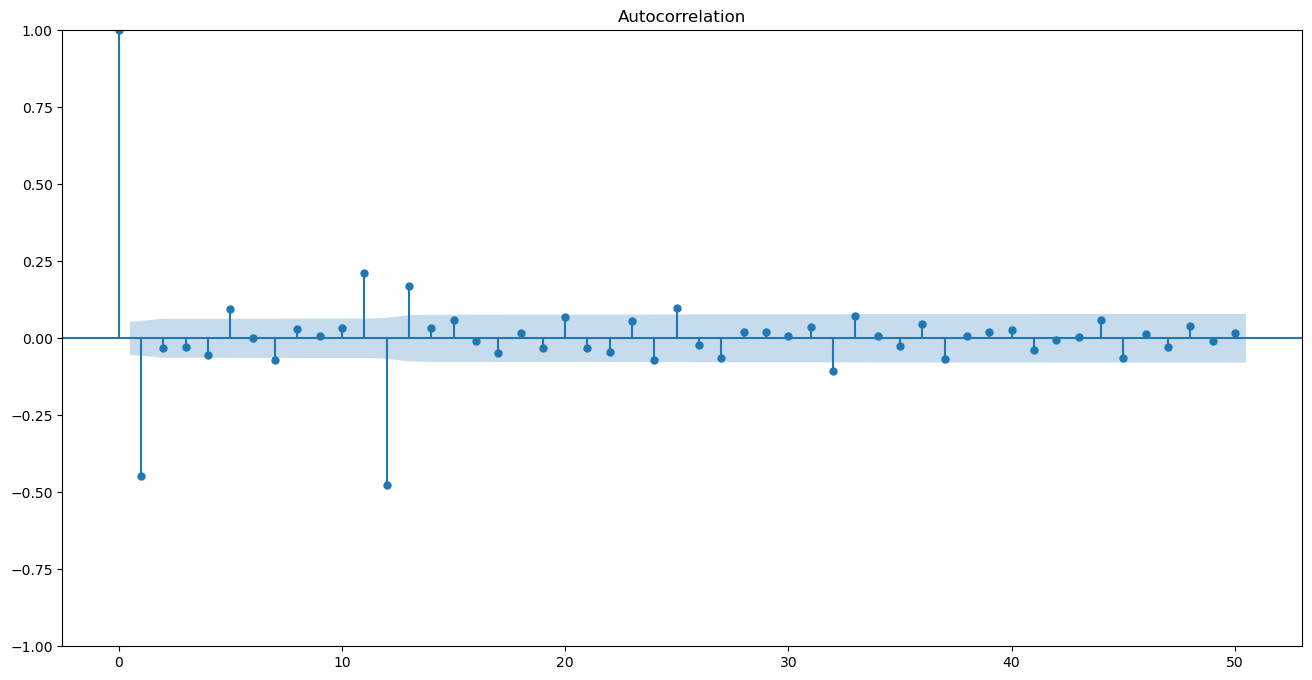

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_nonseasonal['lag1'],lags = 50)

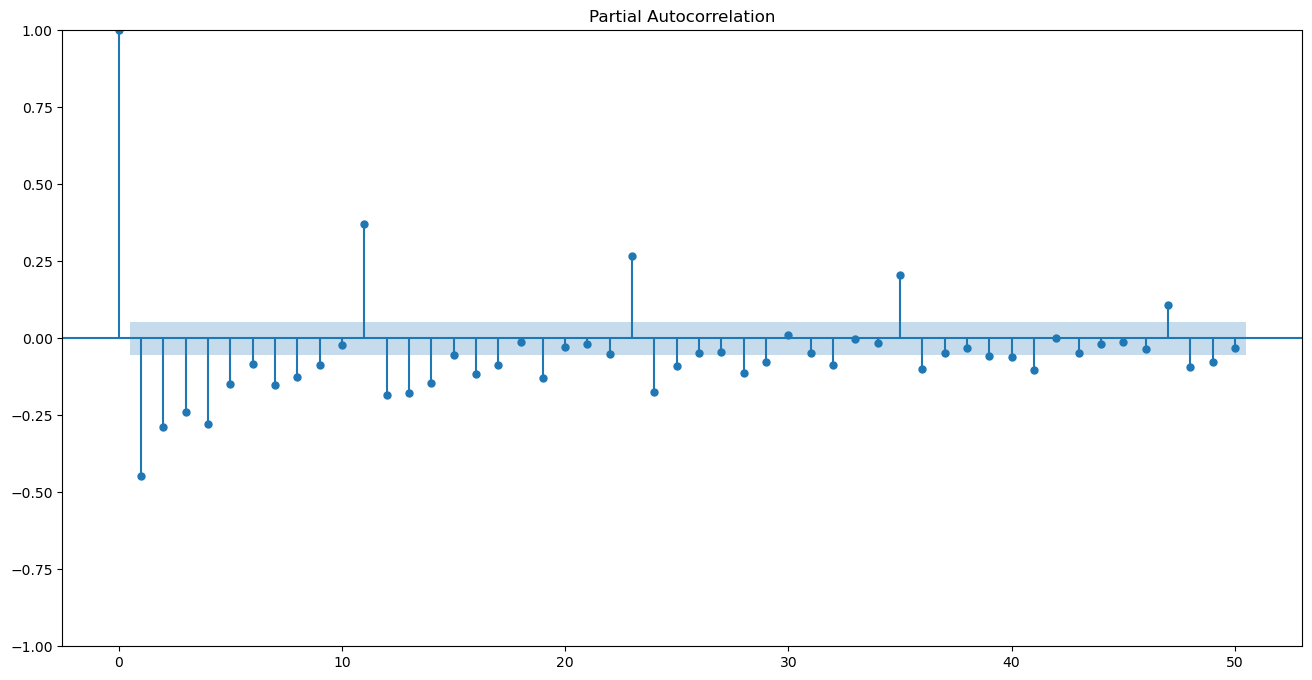

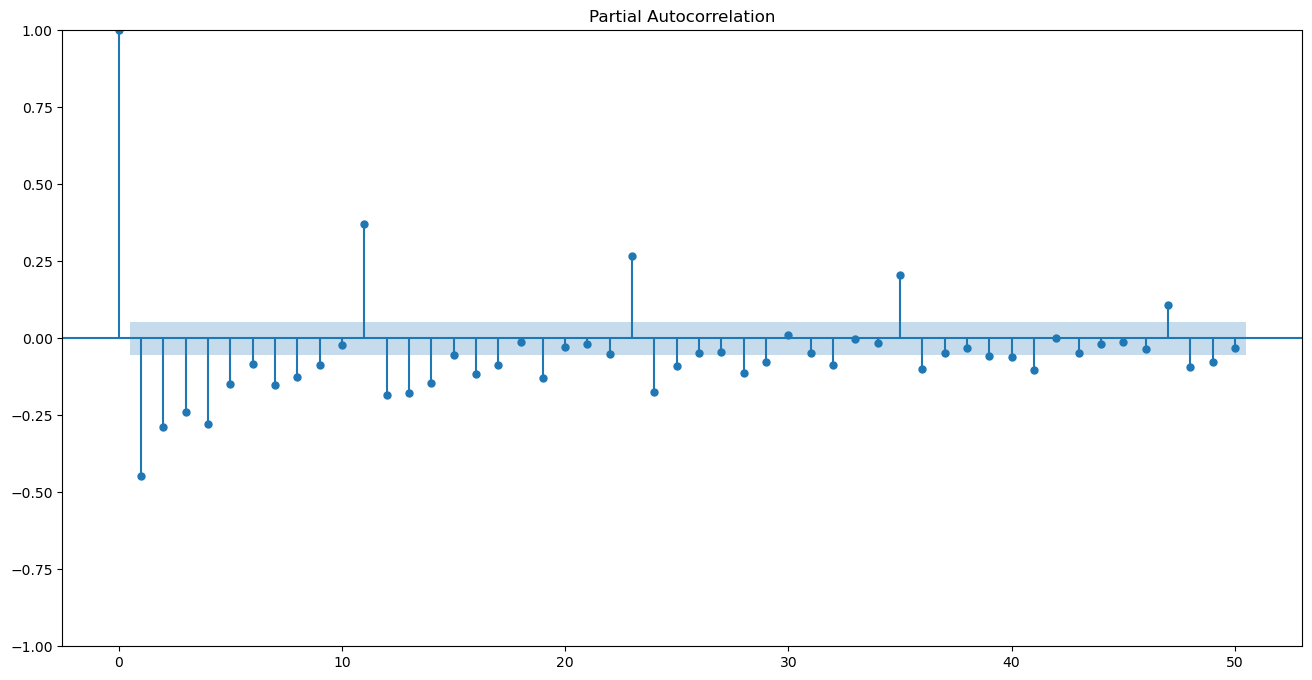

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_nonseasonal['lag1'],lags = 50)

## SARIMA model

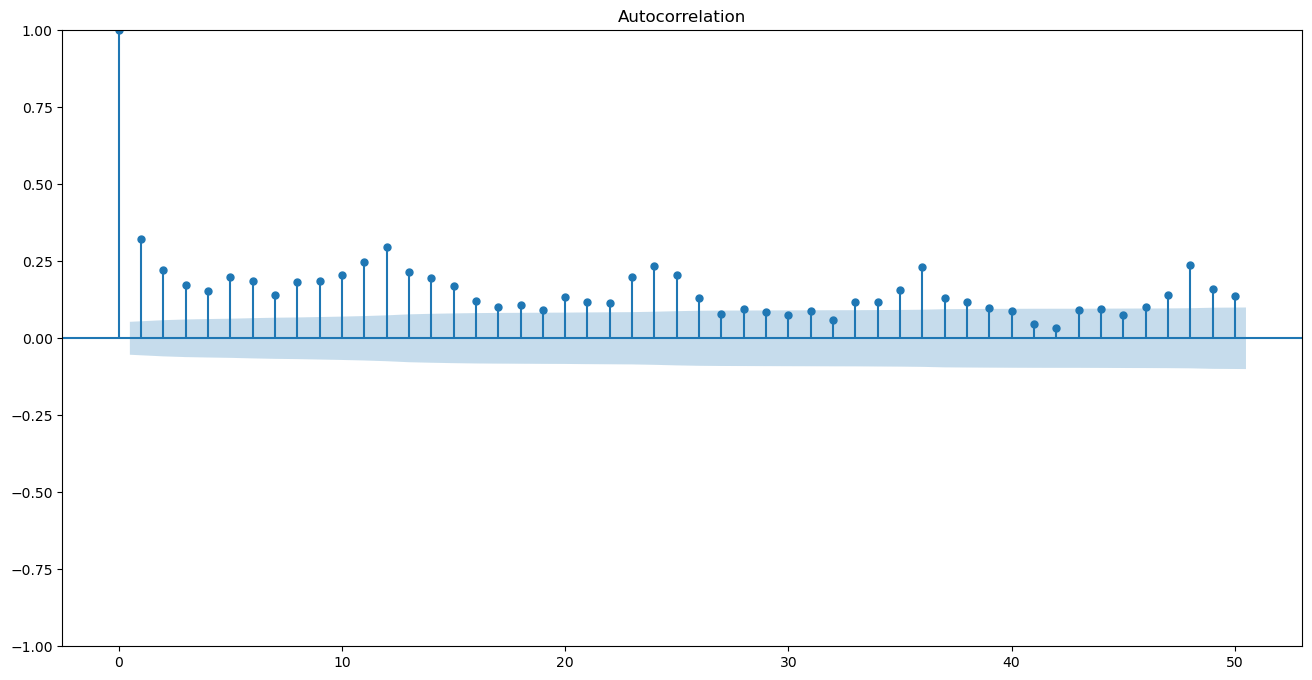

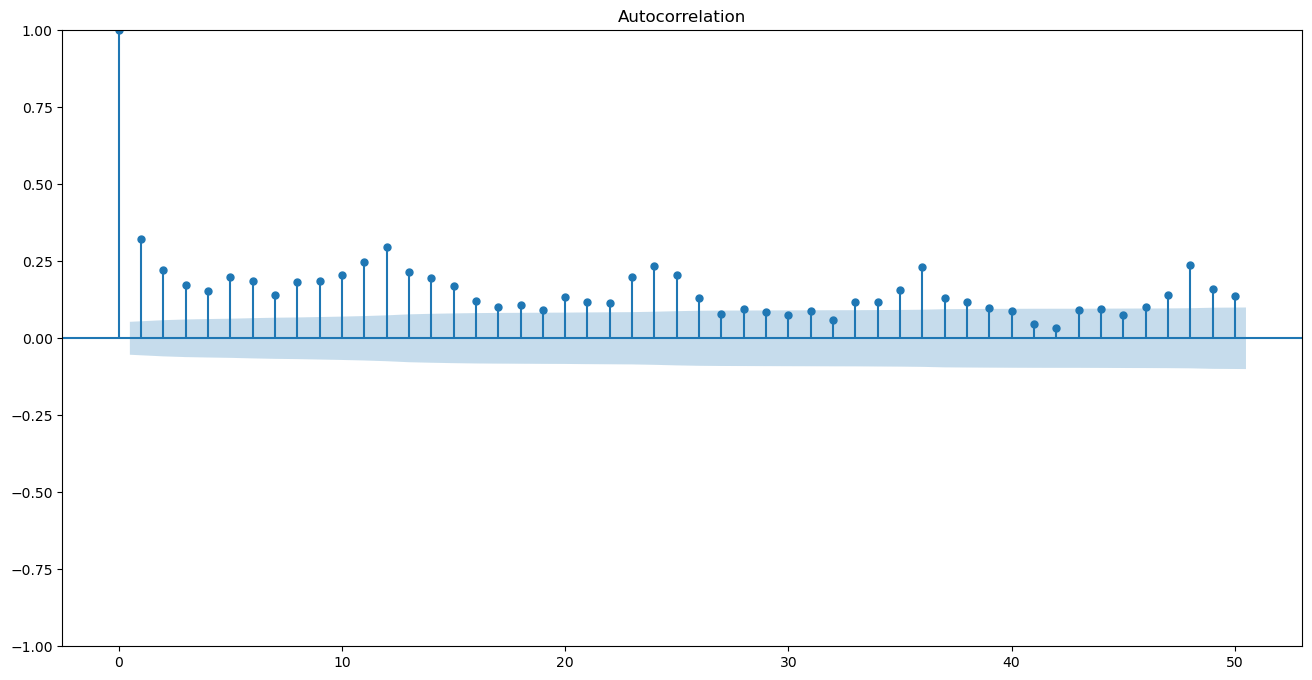

In [25]:

#autocorrelation plots for original data
plot_acf(df['CPI'],lags = 50)

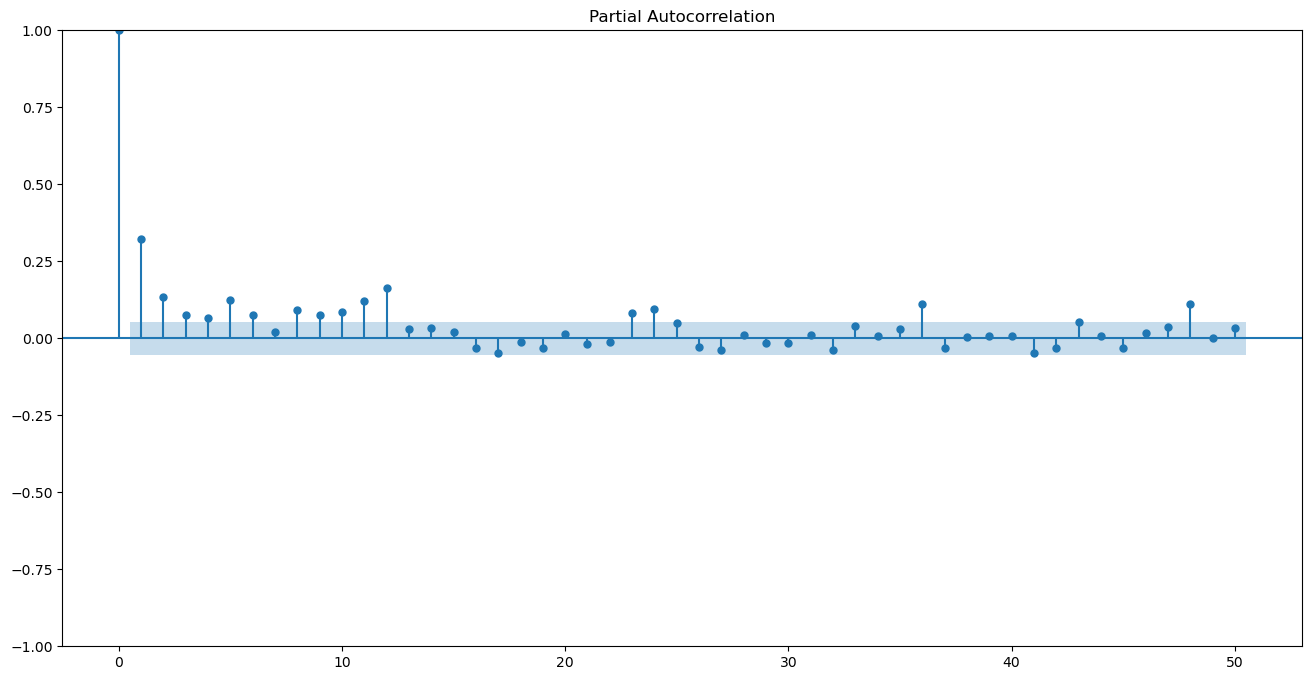

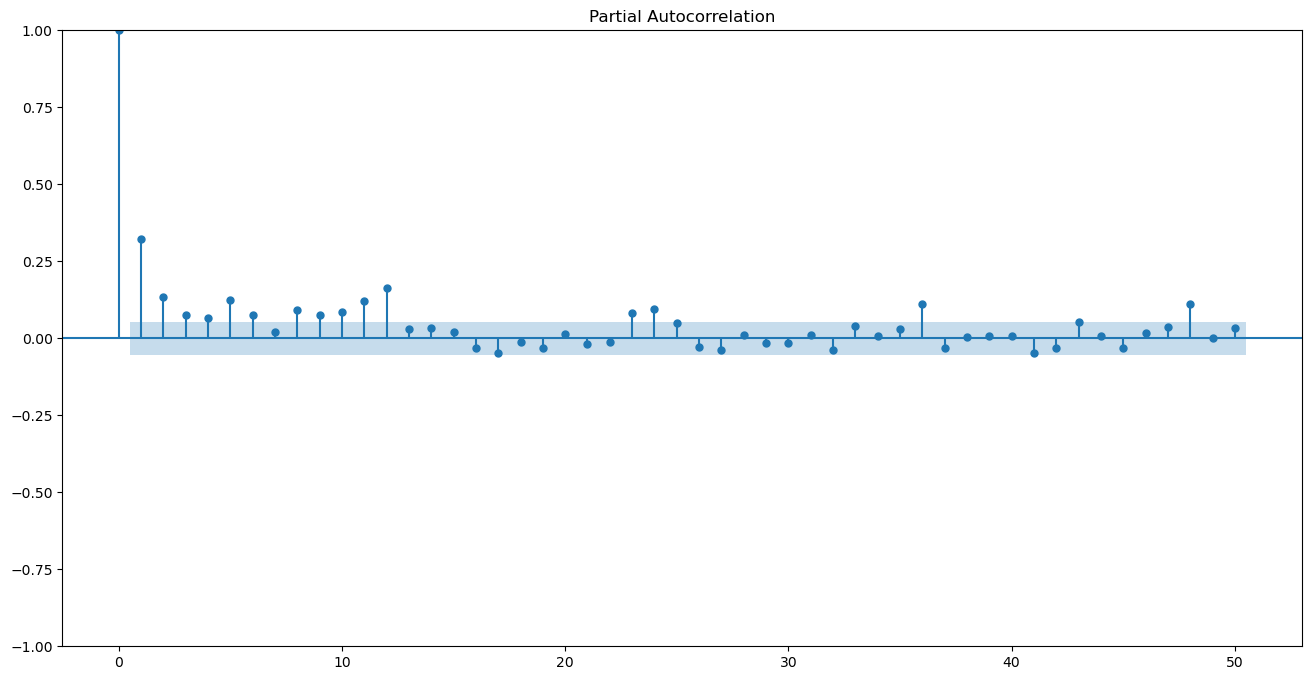

In [26]:
plot_pacf(df['CPI'],lags = 50)

## Train-Test Split

In [27]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_train = df.iloc[:int(0.9*df.shape[0]),:]
SARIMA_test = df.iloc[int(0.9*df.shape[0]):,:]
     

## Model

In [28]:
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

SARIMA_model = SARIMAX(SARIMA_train, order=my_order, seasonal_order=my_seasonal_order)

SARIMA_model_fit = SARIMA_model.fit()
print(SARIMA_model_fit.summary())

c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mkahs\anaconda3\envs\rtx_tf_310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                 1209
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -303.032
Date:                            Wed, 05 Mar 2025   AIC                            612.064
Time:                                    01:00:11   BIC                            627.324
Sample:                                02-01-1913   HQIC                           617.813
                                     - 10-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9068      0.012    -76.935      0.000      -0.930      -0.884
ma.S.L12      -0.9274      0.015   

## Predictions
### Predictions for training data

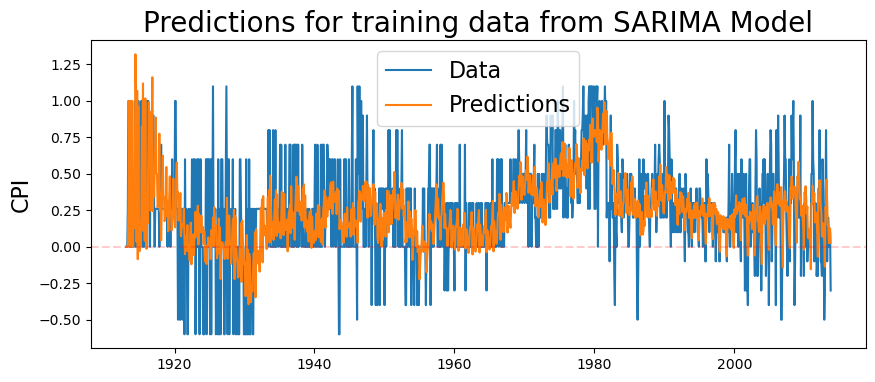

In [29]:

SARIMA_predictions = SARIMA_model_fit.predict(start = SARIMA_train.index[0], end = SARIMA_train.index[-1])
plt.figure(figsize=(10,4))
plt.plot(SARIMA_train)
plt.plot(SARIMA_predictions)
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.title('Predictions for training data from SARIMA Model', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

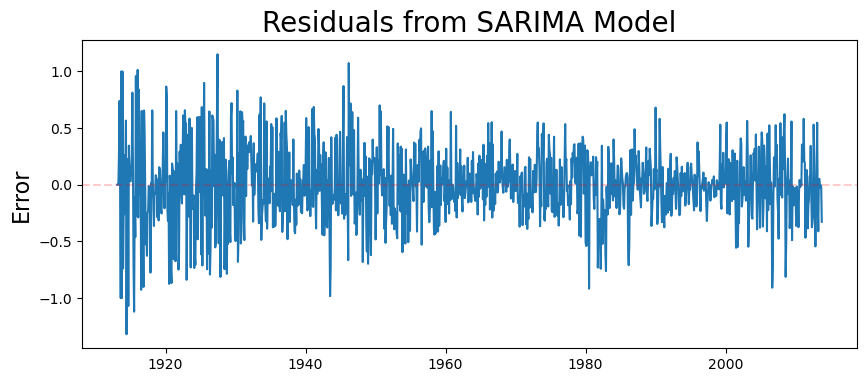

In [30]:

SARIMA_residuals = SARIMA_train['CPI'] - pd.DataFrame(SARIMA_predictions)['predicted_mean']
plt.figure(figsize=(10,4))
plt.plot(SARIMA_residuals)
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [31]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_residuals)),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_residuals**2)))

Mean Absolute Error: 0.2415

Root Mean Squared Error: 0.32113802209933784


## Residual Analysis

In [32]:

#residuals analysis
residuals = [SARIMA_train.iloc[i,:]-SARIMA_predictions[i] for i in
range(len(SARIMA_predictions))]
residuals = pd.DataFrame(residuals)
residuals.head()

C:\Users\mkahs\AppData\Local\Temp\ipykernel_23224\957105244.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  residuals = [SARIMA_train.iloc[i,:]-SARIMA_predictions[i] for i in


,CPI
1913-02-01,0.000000
1913-03-01,0.000000
1913-04-01,0.000000
1913-05-01,0.260045
1913-06-01,0.739955


In [33]:

residuals.describe()

,CPI
count,1209.000000
mean,-0.001717
std,0.321266
min,-1.319897
25%,-0.181883
50%,-0.007485
75%,0.186836
max,1.151611


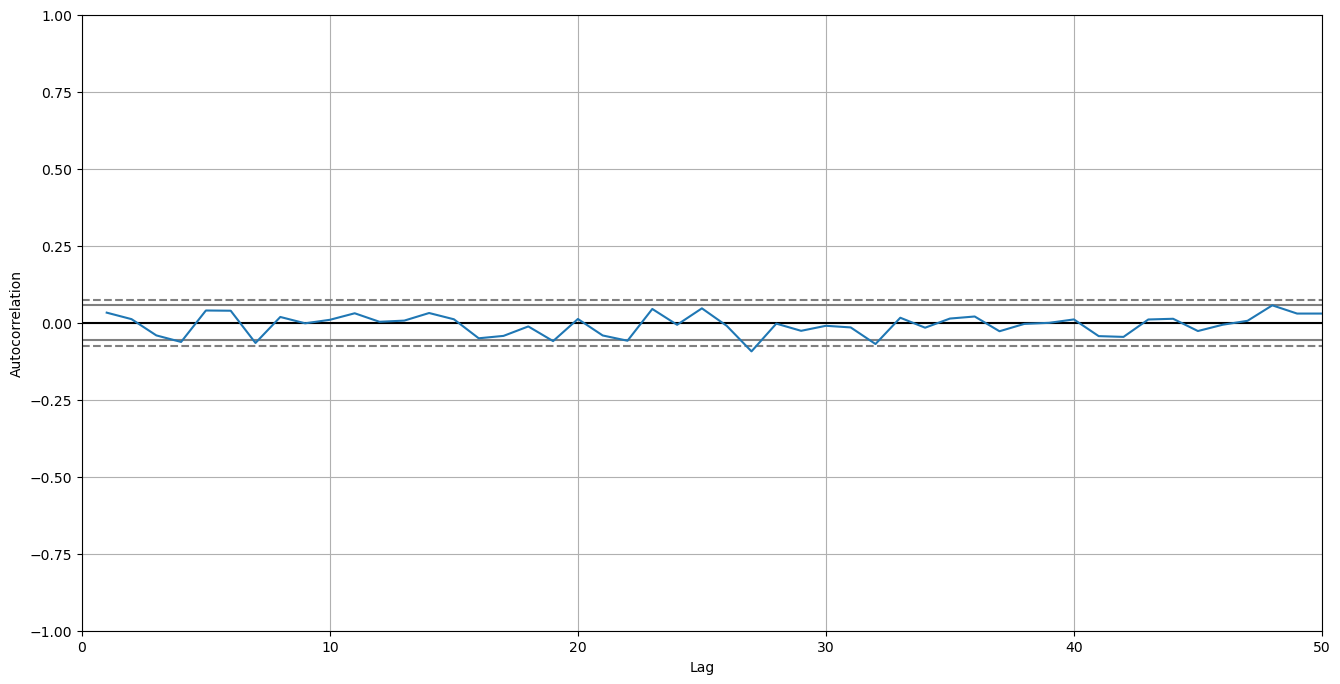

In [34]:
from pandas.plotting import autocorrelation_plot
ax = autocorrelation_plot(np.array(residuals))
ax.set_xlim([0, 50])
plt.show()

In [35]:

df_adf = pd.DataFrame()
df_adf = ADF_Test(residuals,df_adf,0)
df_adf
#residuals are white noise, hence, the model has captured the collinearity well.

,Output,ADF Statistic,p-value,CriticalValues
0,CPI,-13.78486,9.152191e-26,-3.435802
1,CPI,-13.78486,9.152191e-26,-2.863948
2,CPI,-13.78486,9.152191e-26,-2.568052


In [36]:

SARIMA_predictions_test = SARIMA_model_fit.predict(start = SARIMA_test.index[0], end = SARIMA_test.index[-1])
SARIMA_residuals_test = SARIMA_test['CPI'] - pd.DataFrame(SARIMA_predictions_test)['predicted_mean']
     

Text(0, 0.5, 'CPI')

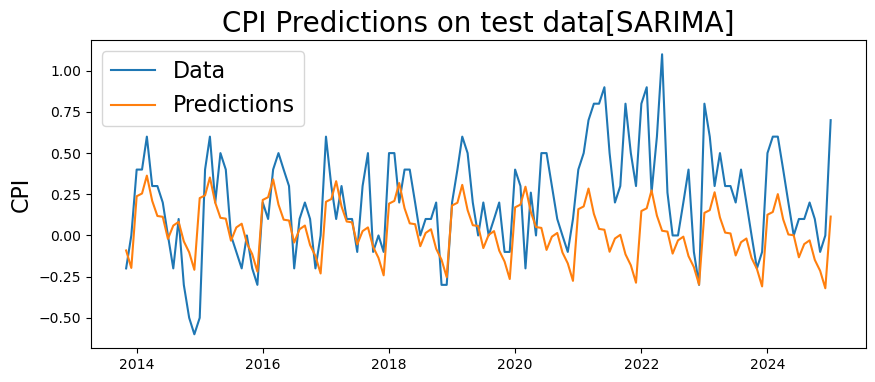

In [37]:

plt.figure(figsize=(10,4))

plt.plot(SARIMA_test)
plt.plot(SARIMA_predictions_test)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title("CPI Predictions on test data[SARIMA]", fontsize=20)
plt.ylabel('CPI', fontsize=16)

In [38]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_residuals_test)),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_residuals_test**2)))

Mean Absolute Error: 0.2488

Root Mean Squared Error: 0.3249987503501285


## Rolling Forecast Origin

In [39]:

from pandas.core.groupby.groupby import Timestamp
from dateutil.relativedelta import relativedelta
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

start_time = datetime(1913,1,1)
end_time = datetime(2014,1,1)

In [40]:

my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

roll_end_time = end_time
SARIMA_roll_train = df.loc[start_time:end_time]

while roll_end_time+relativedelta(months=+1) in df.index:
  
  SARIMA_roll_test = df.loc[roll_end_time:roll_end_time+relativedelta(months=+0)]
  SARIMA_roll_model = SARIMAX(SARIMA_roll_train, order=my_order, seasonal_order=my_seasonal_order)
  SARIMA_roll_model_fit = SARIMA_roll_model.fit()
  SARIMA_roll_predictions = SARIMA_roll_model_fit.predict(start = SARIMA_roll_test.index[0], end = SARIMA_roll_test.index[-1])

  print(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)
  SARIMA_roll_train.loc[roll_end_time] = float(SARIMA_roll_predictions)

2014-01-01 00:00:00
2014-02-01 00:00:00
2014-03-01 00:00:00
2014-04-01 00:00:00
2014-05-01 00:00:00
2014-06-01 00:00:00
2014-07-01 00:00:00
2014-08-01 00:00:00
2014-09-01 00:00:00
2014-10-01 00:00:00
2014-11-01 00:00:00
2014-12-01 00:00:00
2015-01-01 00:00:00
2015-02-01 00:00:00
2015-03-01 00:00:00
2015-04-01 00:00:00
2015-05-01 00:00:00
2015-06-01 00:00:00
2015-07-01 00:00:00
2015-08-01 00:00:00
2015-09-01 00:00:00
2015-10-01 00:00:00
2015-11-01 00:00:00
2015-12-01 00:00:00
2016-01-01 00:00:00
2016-02-01 00:00:00
2016-03-01 00:00:00
2016-04-01 00:00:00
2016-05-01 00:00:00
2016-06-01 00:00:00
2016-07-01 00:00:00
2016-08-01 00:00:00
2016-09-01 00:00:00
2016-10-01 00:00:00
2016-11-01 00:00:00
2016-12-01 00:00:00
2017-01-01 00:00:00
2017-02-01 00:00:00
2017-03-01 00:00:00
2017-04-01 00:00:00
2017-05-01 00:00:00
2017-06-01 00:00:00
2017-07-01 00:00:00
2017-08-01 00:00:00
2017-09-01 00:00:00
2017-10-01 00:00:00
2017-11-01 00:00:00
2017-12-01 00:00:00
2018-01-01 00:00:00
2018-02-01 00:00:00


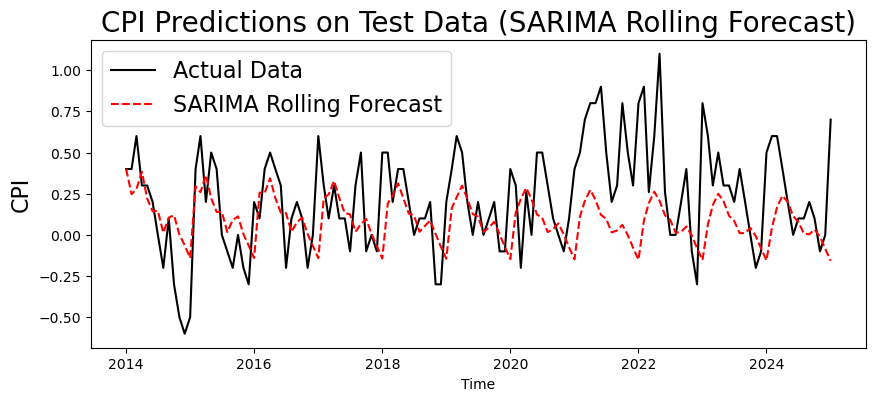

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Plot actual CPI values in black
plt.plot(df.loc[end_time:], label="Actual Data", color="black")

# Plot SARIMA rolling forecast in red dashed line
plt.plot(SARIMA_roll_train.loc[end_time:], label="SARIMA Rolling Forecast", linestyle="--", color="red")

plt.legend(fontsize=16)
plt.title("CPI Predictions on Test Data (SARIMA Rolling Forecast)", fontsize=20)
plt.ylabel("CPI", fontsize=16)
plt.xlabel("Time")
plt.show()


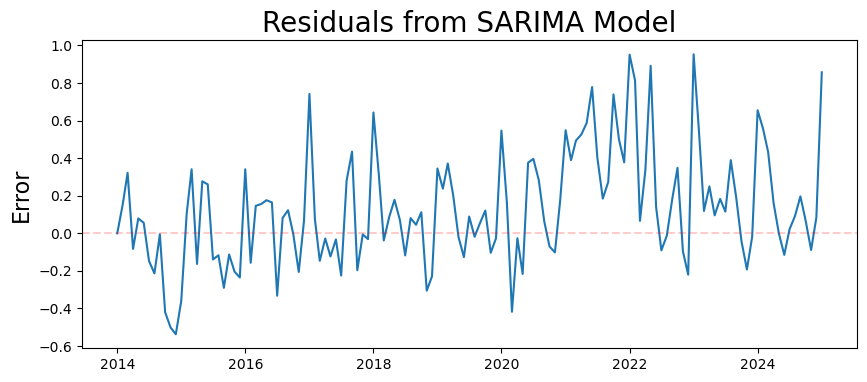

In [42]:

SARIMA_roll_residuals = df.loc[end_time:] - SARIMA_roll_train.loc[end_time:]
plt.figure(figsize=(10,4))
plt.plot(SARIMA_roll_residuals)
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

In [43]:
print('Mean Absolute Error:', round(np.mean(abs(SARIMA_roll_residuals['CPI'])),4))
print('\nRoot Mean Squared Error:', np.sqrt(np.mean(SARIMA_roll_residuals**2)))

Mean Absolute Error: 0.2446

Root Mean Squared Error: 0.32731850460587564


In [44]:

SARIMA_test.tail()

,CPI
timestamp,
2024-09-01,0.2
2024-10-01,0.1
2024-11-01,-0.1
2024-12-01,0.0
2025-01-01,0.7


## Forecasting

In [45]:

#consider entire dataset as training data for estimating forecasts for next 6 months
start_time = datetime(1913,1,1)
end_time = datetime(2025,1,1)

In [46]:

#obtain time series forecasts for the next 6 months
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

roll_end_time = end_time
SARIMA_roll_train = df.loc[start_time:end_time]
c = 0
while c <= 5:
  SARIMA_roll_model = SARIMAX(SARIMA_roll_train, order=my_order, seasonal_order=my_seasonal_order)
  SARIMA_roll_model_fit = SARIMA_roll_model.fit()
  SARIMA_roll_predictions = SARIMA_roll_model_fit.predict(start = roll_end_time, end = roll_end_time+relativedelta(months=+0))

  print(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)
  SARIMA_roll_train.loc[roll_end_time] = float(SARIMA_roll_predictions)
  c += 1

2025-01-01 00:00:00
2025-02-01 00:00:00
2025-03-01 00:00:00
2025-04-01 00:00:00
2025-05-01 00:00:00
2025-06-01 00:00:00


In [47]:

time = []
roll_end_time = end_time + relativedelta(months=+1)
for i in range(6):
  time.append(roll_end_time)
  roll_end_time = roll_end_time + relativedelta(months=+1)

Text(0, 0.5, 'CPI')

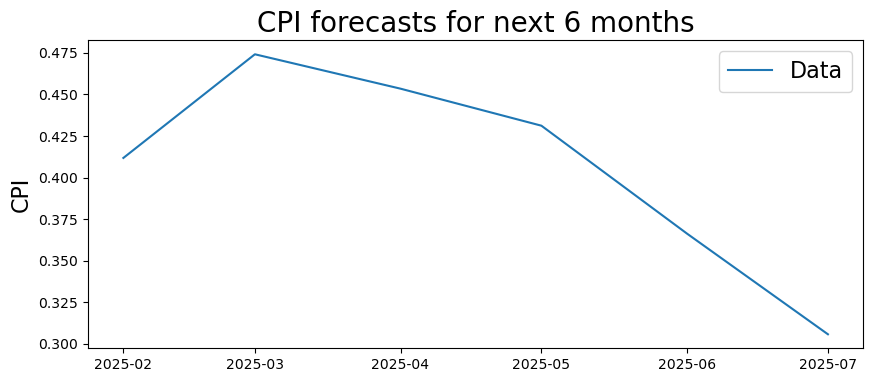

In [48]:

plt.figure(figsize=(10,4))

plt.plot(time, SARIMA_roll_train.loc[end_time+ relativedelta(months=+1):])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('CPI forecasts for next 6 months', fontsize=20)
plt.ylabel('CPI', fontsize=16)
# plt.savefig('forecasts.png')

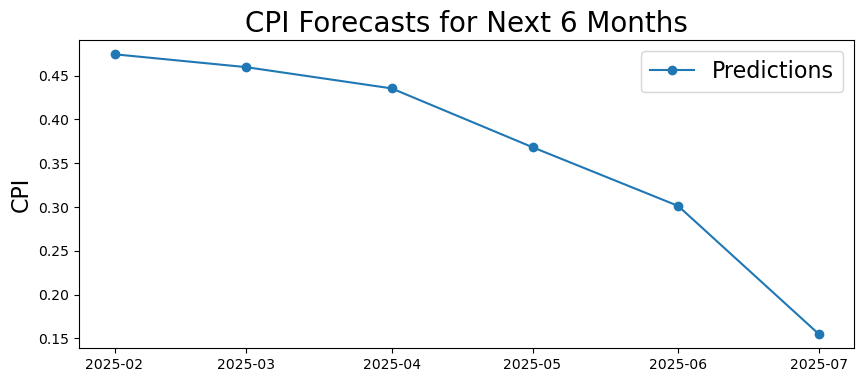

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define training dataset range
start_time = datetime(1913, 1, 1)
end_time = datetime(2025, 2, 1)

# SARIMA model parameters
my_order = (0,1,1)
my_seasonal_order = (0, 1, 1, 12)

# Rolling Forecasting Variables
roll_end_time = end_time
SARIMA_roll_train = df.loc[start_time:end_time].copy()  # Copy to avoid modifying original dataframe
forecast_dates = []
forecast_values = []

# Forecast for the next 6 months
for _ in range(6):
    # Fit SARIMA model
    SARIMA_roll_model = SARIMAX(SARIMA_roll_train, order=my_order, seasonal_order=my_seasonal_order)
    SARIMA_roll_model_fit = SARIMA_roll_model.fit()

    # Get the forecast for the next time step
    SARIMA_roll_prediction = SARIMA_roll_model_fit.predict(start=roll_end_time, end=roll_end_time)

    # Store forecasted values
    forecast_dates.append(roll_end_time)
    forecast_values.append(float(SARIMA_roll_prediction))

    # Update training data with forecasted value
    SARIMA_roll_train.loc[roll_end_time] = float(SARIMA_roll_prediction)

    # Move to the next month
    roll_end_time += relativedelta(months=1)

# Create DataFrame
forecast_df = pd.DataFrame({'Date': forecast_dates, 'CPI_Forecast': forecast_values})

# # Display the DataFrame
# import ace_tools as tools
# tools.display_dataframe_to_user(name="CPI Forecast Data", dataframe=forecast_df)

# Plot forecasts
plt.figure(figsize=(10, 4))
plt.plot(forecast_df['Date'], forecast_df['CPI_Forecast'], marker='o', linestyle='-')
plt.legend(['Predictions'], fontsize=16)
plt.title('CPI Forecasts for Next 6 Months', fontsize=20)
plt.ylabel('CPI', fontsize=16)
plt.show()


In [51]:
forecast_df.head(10)

,Date,CPI_Forecast
0,2025-01-01,0.411803
1,2025-02-01,0.445033
2,2025-03-01,0.430901
3,2025-04-01,0.406382
4,2025-05-01,0.339135
5,2025-06-01,0.272659


In [58]:
# Define the output Excel file name
output_excel_file = "CPI_Forecast_SARIMA_Rolling_Next_6_Months.xlsx"

# Save the forecast DataFrame to an Excel file
forecast_df.to_excel(output_excel_file, index=False)

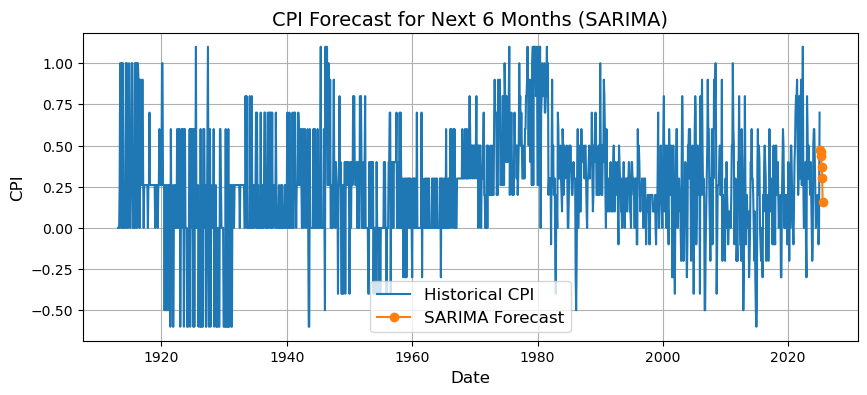

,Date,CPI_Forecast
0,2025-02-01,0.474334
1,2025-03-01,0.459676
2,2025-04-01,0.435407
3,2025-05-01,0.368257
4,2025-06-01,0.301205
5,2025-07-01,0.154686


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the existing CPI dataset from the notebook
df = df.copy()  # Ensure the dataset is available

# Define SARIMA parameters (from notebook settings)
my_order = (0, 1, 1)
my_seasonal_order = (0, 1, 1, 12)

# Define the last available date in the dataset
end_time = df.index[-1]

# Fit SARIMA model using the full dataset
sarima_model = SARIMAX(df, order=my_order, seasonal_order=my_seasonal_order)
sarima_model_fit = sarima_model.fit()

# Generate next 6-month forecast
future_dates = [end_time + relativedelta(months=i) for i in range(1, 7)]
sarima_forecast = sarima_model_fit.predict(start=future_dates[0], end=future_dates[-1])

# Create a DataFrame for forecasted values
sarima_forecast_df = pd.DataFrame({'Date': future_dates, 'CPI_Forecast': sarima_forecast.values})

# Save forecast results to an Excel file
sarima_output_file = "CPI_Forecast_SARIMA_Next_6_Months.xlsx"
sarima_forecast_df.to_excel(sarima_output_file, index=False)

# Plot SARIMA Forecast
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
plt.plot(sarima_forecast_df['Date'], sarima_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="SARIMA Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 6 Months (SARIMA)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

# # Return the saved file path
# sarima_output_file


sarima_forecast_df.head(10)

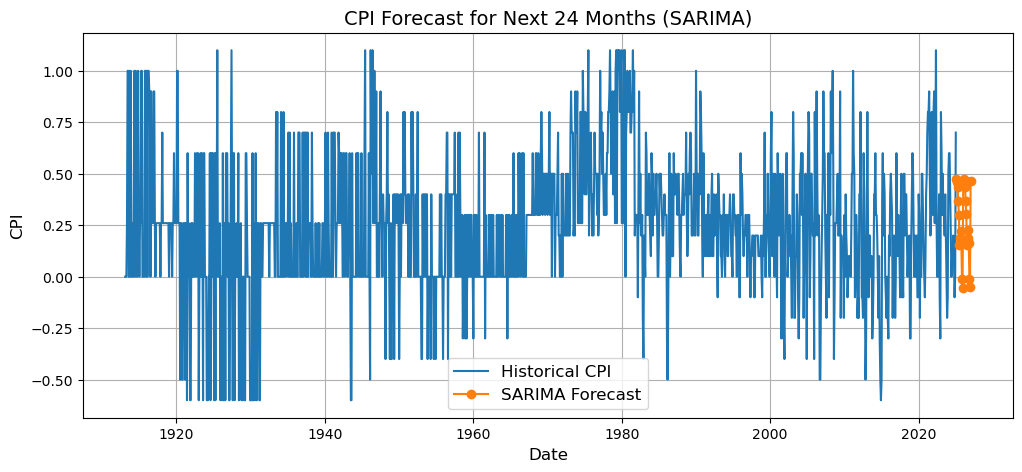

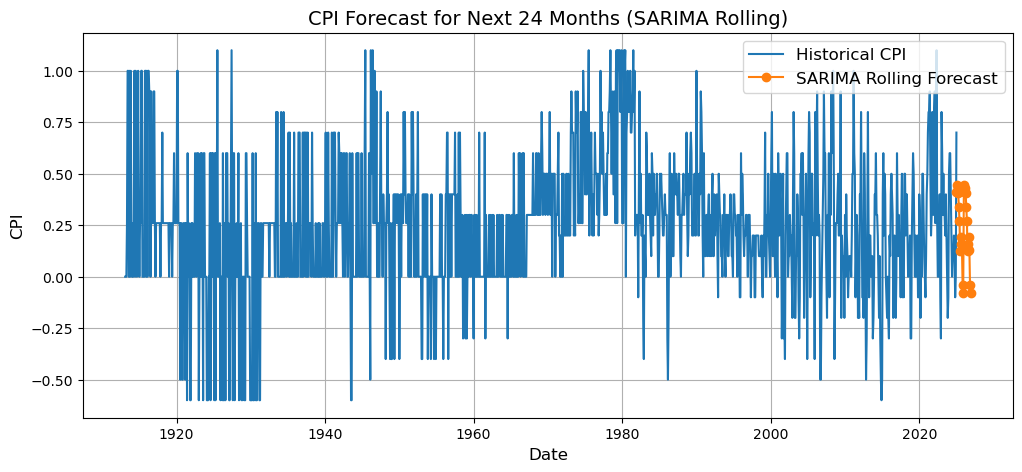

In [62]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure df is defined
if 'df' not in locals():
    raise ValueError("The dataset 'df' is not defined. Please provide a DataFrame with CPI time series data.")

# Define SARIMA parameters
my_order = (0, 1, 1)
my_seasonal_order = (0, 1, 1, 12)

# Define the last available date in the dataset
end_time = df.index[-1]

# Fit SARIMA model using the full dataset
sarima_model = SARIMAX(df, order=my_order, seasonal_order=my_seasonal_order)
sarima_model_fit = sarima_model.fit()

# Generate next 24-month forecast
future_dates = [end_time + relativedelta(months=i) for i in range(1, 25)]
sarima_forecast = sarima_model_fit.predict(start=future_dates[0], end=future_dates[-1])

# Create a DataFrame for forecasted values
sarima_forecast_df = pd.DataFrame({'Date': future_dates, 'CPI_Forecast': sarima_forecast.values})

# Save forecast results to an Excel file
sarima_output_file = "CPI_Forecast_SARIMA_Next_24_Months.xlsx"
sarima_forecast_df.to_excel(sarima_output_file, index=False)

# --- Rolling SARIMA Forecast --- #
roll_end_time = end_time
sarima_roll_forecast_dates = []
sarima_roll_forecast_values = []
sarima_roll_train = df.copy()

for _ in range(24):
    sarima_roll_model = SARIMAX(sarima_roll_train, order=my_order, seasonal_order=my_seasonal_order)
    sarima_roll_model_fit = sarima_roll_model.fit()

    sarima_roll_prediction = sarima_roll_model_fit.predict(start=roll_end_time, end=roll_end_time)

    sarima_roll_forecast_dates.append(roll_end_time)
    sarima_roll_forecast_values.append(float(sarima_roll_prediction))

    # Update training data with forecasted value
    sarima_roll_train.loc[roll_end_time] = float(sarima_roll_prediction)

    # Move to the next month
    roll_end_time += relativedelta(months=1)

# Create DataFrame for rolling forecast
sarima_roll_forecast_df = pd.DataFrame({'Date': sarima_roll_forecast_dates, 'CPI_Forecast': sarima_roll_forecast_values})

# Save rolling forecast to an Excel file
sarima_roll_output_file = "CPI_Forecast_SARIMA_Rolling_Next_24_Months.xlsx"
sarima_roll_forecast_df.to_excel(sarima_roll_output_file, index=False)

# --- Plotting Results --- #
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
plt.plot(sarima_forecast_df['Date'], sarima_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="SARIMA Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 24 Months (SARIMA)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['CPI'], label="Historical CPI", linestyle='-')
plt.plot(sarima_roll_forecast_df['Date'], sarima_roll_forecast_df['CPI_Forecast'], marker='o', linestyle='-', label="SARIMA Rolling Forecast")
plt.legend(fontsize=12)
plt.title('CPI Forecast for Next 24 Months (SARIMA Rolling)', fontsize=14)
plt.ylabel('CPI', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)
plt.show()

# # Return saved file paths
# sarima_output_file, sarima_roll_output_file


In [60]:
sarima_forecast_df.head(30)

,Date,CPI_Forecast
0,2025-02-01,0.474334
1,2025-03-01,0.459676
2,2025-04-01,0.435407
3,2025-05-01,0.368257
4,2025-06-01,0.301205
5,2025-07-01,0.154686
6,2025-08-01,0.188301
7,2025-09-01,0.223518
8,2025-10-01,0.160911
9,2025-11-01,-0.013587


In [61]:
sarima_roll_forecast_df.head(30)

,Date,CPI_Forecast
0,2025-01-01,0.411803
1,2025-02-01,0.445033
2,2025-03-01,0.430901
3,2025-04-01,0.406382
4,2025-05-01,0.339135
5,2025-06-01,0.272659
6,2025-07-01,0.126246
7,2025-08-01,0.159805
8,2025-09-01,0.195177
9,2025-10-01,0.132435
